In [25]:
#https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output

import pandas as pd
import numpy as np
import time
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import tensorflow as tf

In [129]:
def build_model2(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    model = Sequential()
    model.add(LSTM((32),input_shape = (input_timesteps, num_inputs, 1, 1),return_sequences = False))    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(Dense(units=1, name = 'dense_2'))
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

    
    return model

In [29]:
def create_time_steps(length):
    return list(range(-length, 0))
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [116]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 

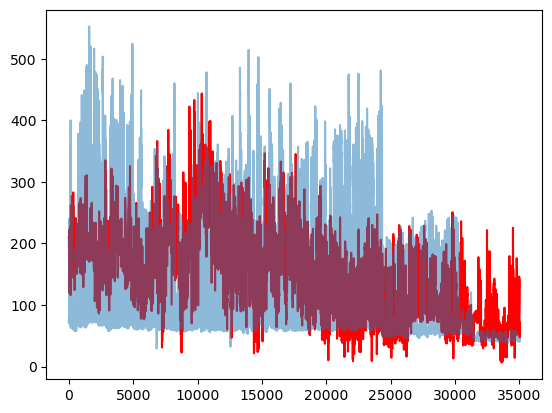

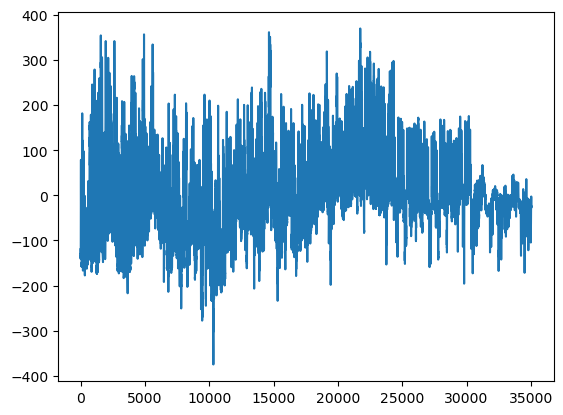

In [117]:
df['production_usage'].plot(color="red")
df['consumption_usage'].plot(alpha=0.5)
plt.show()

df['diff'] = df['consumption_usage'] - df['production_usage']
df['diff'].plot()
plt.show()

In [118]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 1000
TRAIN_SPLIT = 32000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

features_considered =  [
                    'consumption_usage','production_usage','price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
features = df[features_considered]
features.index = df['date']
features.head()

,consumption_usage,production_usage,price,isWeekend,isHoliday,temp,wind,day_cos,day_sin,month_cos,month_sin
date,,,,,,,,,,,
2020-01-01 00:00:00,76.404,195.8824,33.2,0,1,-8.0,3,1.000000,0.000000,0.999963,-0.008601
2020-01-01 00:15:00,72.212,212.0020,33.2,0,1,-8.0,3,1.000000,0.000000,0.999965,-0.008422
2020-01-01 00:30:00,70.992,210.3493,33.2,0,1,-8.0,3,1.000000,0.000000,0.999966,-0.008243
2020-01-01 00:45:00,70.872,209.2419,33.2,0,1,-8.0,3,1.000000,0.000000,0.999967,-0.008064
2020-01-01 01:00:00,80.540,211.9544,30.4,0,1,-8.4,3,0.965926,0.258819,0.999969,-0.007884


In [121]:
dataset = features.values
# data_mean = dataset[:TRAIN_SPLIT].mean()
# data_std = dataset[:TRAIN_SPLIT].std()
# dataset = (dataset-data_mean)/data_std

In [122]:
dataset

array([[ 7.64040000e+01,  1.95882400e+02,  3.32000000e+01, ...,
         0.00000000e+00,  9.99963010e-01, -8.60110587e-03],
       [ 7.22120000e+01,  2.12002000e+02,  3.32000000e+01, ...,
         0.00000000e+00,  9.99964535e-01, -8.42192044e-03],
       [ 7.09920000e+01,  2.10349300e+02,  3.32000000e+01, ...,
         0.00000000e+00,  9.99966028e-01, -8.24273475e-03],
       ...,
       [ 4.52400000e+01,  7.06636000e+01,  3.53000000e+01, ...,
        -2.58819045e-01,  9.30621014e-01, -3.65984328e-01],
       [ 4.43040000e+01,  7.07882000e+01,  3.53000000e+01, ...,
        -2.58819045e-01,  9.30686580e-01, -3.65817562e-01],
       [ 4.58640000e+01,  7.09464000e+01,  3.53000000e+01, ...,
        -2.58819045e-01,  9.30752117e-01, -3.65650785e-01]])

In [135]:
future_target = 72
past_history = 90
STEP = 1
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [132]:
EPOCHS = 30
steps_per_epoch = 10
validation_steps = 500

# modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
print(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
model = build_model2(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
# model.save('multi-output-timesteps.h5')
# print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

15 72 2 2
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 15, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 2, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 2, 1, 64)          256       
_________________________________________________________________
flatten_10 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 72, 128)           0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 72, 2, 

KeyboardInterrupt: 

In [ ]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))